In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA

from lfads_torch.post_run.band_analysis import run_posterior_sampling
from lfads_torch.metrics import r2_score


Matplotlib created a temporary cache directory at /tmp/matplotlib-y024vu0r because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
dataset_name = 'chewie_10_07_small'

bin_size_ms = 10

In [4]:
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/pbt/{dataset_name}"

fac_dim, co_dim = 8,4
bw = 0.1
n_neurons = 207
seed = 2
# model_names = ['240520_lfads_minloss_KL1', '240520_band_minloss_KL1']
model_names = [f'lfads_{fac_dim}f_{co_dim}c_minloss_KL1_normal01_sample1',f'band_{fac_dim}f_{co_dim}c_minloss_KL1_normal01_sample1']
model_dests = [f"{models_dest}/{model_name}" for model_name in model_names]


In [5]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.utils import flatten

overrides={
        "datamodule": dataset_name,
        "model": dataset_name,
        "model.fac_dim": fac_dim,
        "model.co_dim": co_dim,

    }
config_path="../../configs/pbt.yaml"
print(config_path)

# Compose the train config with properly formatted overrides
config_path = Path(config_path)
overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
with hydra.initialize(
    config_path=config_path.parent,
    job_name="get_weights",
    version_base="1.1",
):
    config = hydra.compose(config_name=config_path.name, overrides=overrides)

# Instantiate `LightningDataModule` and `LightningModule`
datamodule = instantiate(config.datamodule, _convert_="all")
model = instantiate(config.model)

from glob import glob
checkpoint_folders = glob(model_dests[-1]+'/best_model/checkpoint*')

ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
# ckpt_path = f'{model_dest}/lightning_checkpoints/last.ckpt'
model.load_state_dict(torch.load(ckpt_path)["state_dict"])

../../configs/pbt.yaml


<All keys matched successfully>

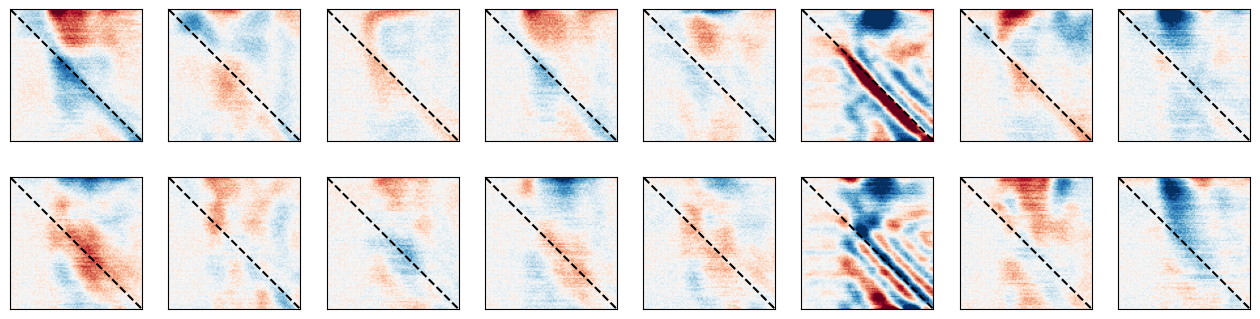

In [7]:
seq_len = config.model.recon_seq_len
in_features = config.model.behavior_readout.modules[0].in_features
out_features = config.model.behavior_readout.modules[0].out_features
beh_W = model.behavior_readout[0].layers[1].weight.T

assert beh_W.shape == (in_features*seq_len, out_features*seq_len)

beh_W = beh_W.reshape((seq_len, in_features, seq_len, out_features))

r = torch.std(beh_W)*4
fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features))
for j in range(in_features):
    for i in range(out_features):
        ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].plot([0,seq_len-1], [0, seq_len-1], 'k--')

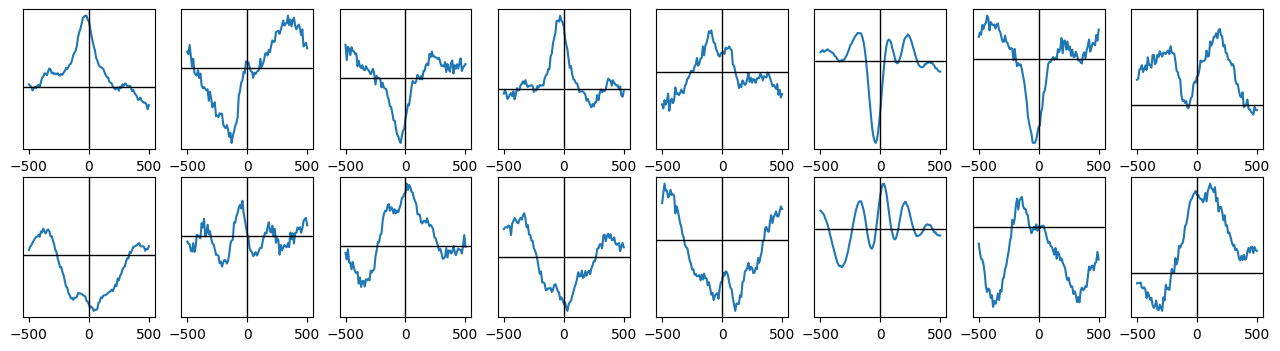

In [35]:
r = torch.std(beh_W)*4
fig, ax = plt.subplots(out_features, in_features, figsize=(2*in_features, 2*out_features),sharey='col')
for j in range(in_features):
    for i in range(out_features):
        w = beh_W[:,j,:,i].detach().numpy()[25:,25:]
        lags = np.arange(-50, 51)
        amp = np.zeros_like(lags, dtype=float)
        for k,lag in enumerate(lags):
            amp[k] = np.mean(np.diag(w, k=lag))
        ax[i,j].plot(10*lags,amp)
        ax[i,j].axhline(0, color='k', linewidth=1)
        ax[i,j].axvline(0, color='k', linewidth=1)
        ax[i,j].set_yticks([])

In [8]:
# load the dataset
assert len(config.datamodule.data_paths) == 1, 'Assumed a single dataset, got more'
dataset_filename = config.datamodule.data_paths[0] 

with h5py.File(dataset_filename, 'r') as f:
    train_data = f['train_recon_data'][:]
    valid_data = f['valid_recon_data'][:]
    train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
    train_epoch = f["train_epoch"][:]
    valid_epoch = f["valid_epoch"][:]
    true_train_beh = f['train_vel'][:]
    true_valid_beh = f['valid_vel'][:]
    true_target_direction = f['valid_target_direction'][:]

true_pos = np.cumsum(true_valid_beh,axis=1) 

def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
    n_samples = len(train_data) + len(valid_data)
    merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
    merged_data[train_inds] = train_data
    merged_data[valid_inds] = valid_data
    return merged_data

# Get the paths to all data files
both_factors = []
both_train_factors = []
both_factors_noci = []
both_train_factors_noci = []
both_controls = []
both_control_means = []
both_control_stds = []
both_rates = []
both_train_rates = []
both_noci_rates = []
both_train_noci_rates = []
both_ics = []
both_behaviors = []
lin_decoded_behs = []
seq2seq_decoded_behs = []
control_decoded_behs = []
ridge_models_0_lag = []
for model_name in model_names:
    print(model_name)
    data_path = os.path.join(models_dest,model_name,'best_model','lfads_output_sess0.h5')
    bin_width_s = .01 # chewie
    # Data is binned at 10 ms
    with h5py.File(data_path) as f:
        print(f.keys())
        # Merge train and valid data for factors and rates
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        factors = f["valid_factors"][:]
        rates = f["valid_output_params"][:] / bin_width_s
        behavior = f["valid_output_behavior_params"][:]
        controls = f['valid_gen_inputs'][:]
        ic = f['valid_gen_init'][:]
        control_mean = f['valid_co_means'][:]
        control_stds = f['valid_co_stds'][:]

        train_factors = f["train_factors"][:]
        train_controls = f['train_gen_inputs'][:]
        train_ic = f['train_gen_init'][:]
        train_rates = f["train_output_params"][:] / bin_width_s

    # load ablated model components
    data_path = os.path.join(models_dest,model_name,'best_model','lfads_ablated_output_sess0.h5')
    with h5py.File(data_path) as f:
        noci_factors = f["valid_factors"][:]
        noci_train_factors = f["train_factors"][:]
        noci_behavior = f["valid_output_behavior_params"][:]

        noci_rates = f["valid_output_params"][:] / bin_width_s
        noci_train_rates = f["train_output_params"][:] / bin_width_s
        # noci_controls = f['valid_gen_inputs'][:]
    
    # train Ridge regression to predict behavior from factors (0lag)
    X_train = train_factors.reshape(-1,train_factors.shape[-1])
    Y_train = true_train_beh.reshape(-1,true_train_beh.shape[-1])
    X_test = factors.reshape(-1,factors.shape[-1])
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_0lag = ridge.predict(X_test).reshape(true_valid_beh.shape)
    ridge_models_0_lag.append(ridge)

    # Ridge seq2seq
    X_train = train_factors.reshape(train_factors.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = factors.reshape(factors.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge from control inputs (seq2seq)
    X_train = train_controls.reshape(train_controls.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = controls.reshape(controls.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_control = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge from log firing rates (seq2seq)
    X_train = np.log(train_rates.reshape(train_rates.shape[0],-1))
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = np.log(rates.reshape(rates.shape[0],-1))
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_seq2seq_rates = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    print(train_ic.shape,ic_pca.shape)
            
    both_factors.append(factors)
    both_train_factors.append(train_factors)
    both_factors_noci.append(noci_factors)
    both_train_factors_noci.append(noci_train_factors)
    both_controls.append(controls)
    both_control_means.append(control_mean)
    both_control_stds.append(control_stds)
    both_rates.append(rates)
    both_train_rates.append(train_rates)
    both_noci_rates.append(noci_rates)
    both_train_noci_rates.append(noci_train_rates)
    both_ics.append(ic_pca)
    both_behaviors.append(behavior)
    lin_decoded_behs.append(Y_pred_0lag)
    seq2seq_decoded_behs.append(Y_pred_seq2seq)
    control_decoded_behs.append(Y_pred_control)

lfads_8f_4c_minloss_KL1_normal01_sample1
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(465, 200) (116, 2)
band_8f_4c_minloss_KL1_normal01_sample1
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_

# Plot firing rate difference with/without controls

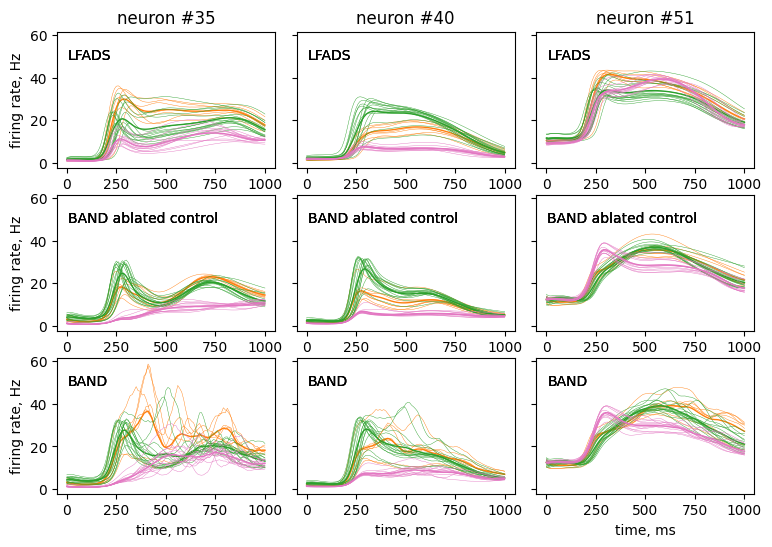

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(9, 6), sharey=True)

for k, (n, sub) in enumerate(zip([35, 40, 51], [[1, 2, 6], [1,2, 6], [1,2, 6]])):
    unique_dirs = np.unique(true_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([both_rates[0], both_noci_rates[1], both_rates[1]],
                                        ['LFADS', 'BAND ablated control', 'BAND'])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = true_target_direction == d
                axes[i, k].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[i, k].plot(
                    time, frs[mask][..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[0, k].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[i, k].set_ylabel("firing rate, Hz")
                axes[i, k].set_xlabel("time, ms")
                axes[i, k].text(0.05, 0.8, title, transform=axes[i, k].transAxes, ha='left')
                # axes[i, k].set_ylim([0, 65])

# axes[0, 0].set_title("LFADS")
# axes[0, 1].set_title("Ctrl-TNDM")

# plt.legend(loc=(1.5, 0))
plt.subplots_adjust(wspace=0.1)
plt.savefig(f"fig3c.svg")

In [10]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

# widget to scroll through trials
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

@widgets.interact
def plot_trial(trial_id=widgets.IntSlider(min=0, max=valid_data.shape[0]-1, step=1, value=0)):

    fig = plt.figure(figsize=(10, 4))

    # blank = fig.add_axes([0,0,1,1], frameon=True)

    axis_IC = fig.add_axes([0.05, 0.6, 0.1, 0.25])

    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    # print(train_ic.shape,ic_pca.shape)

    axis_IC.set_title('Initial Conditions')
    axis_IC.scatter(*ic_pca.T,c=cm.rainbow(get_target_ids(true_target_direction)/8),s=2)
    axis_IC.scatter(*ic_pca[trial_id],c='k',
                    s=50,marker='*')
    axis_IC.scatter(*ic_pca[trial_id],c=cm.rainbow(get_target_ids(true_target_direction)/8)[trial_id],
                    s=20,marker='*')
    axis_IC.set_xlabel('PC1')
    axis_IC.set_ylabel('PC2')
    axis_IC.set_xticks([])
    axis_IC.set_yticks([])

    time = np.arange(controls.shape[1])*bin_size_ms
    axis_controls = fig.add_axes([0.05, 0.15, 0.25, 0.25])
    axis_controls.set_title('Controls')
    axis_controls.plot(time,controls[trial_id])
    axis_controls.set_xlabel('Time (ms)')
    axis_controls.set_ylabel('Control input')

    axis_factors = fig.add_axes([0.38, 0.6, 0.25, 0.25])
    axis_factors.set_title('Autonomous Factors')
    axis_factors.plot(time,(noci_factors[trial_id] - noci_factors[trial_id].mean(0))[:])
    axis_factors.set_xlabel('Time (ms)')
    axis_factors.set_ylabel('Factor')

    axis_noci_factors = fig.add_axes([0.38, 0.15, 0.25, 0.25])
    axis_noci_factors.set_title('Controlled Factors')
    axis_noci_factors.plot(time,(factors[trial_id] - factors[trial_id].mean(0))[:])
    axis_noci_factors.set_xlabel('Time (ms)')
    axis_noci_factors.set_ylabel('Factor')

    # draw an arrow from IC to autonomous factors

    axis_noci_behavior = fig.add_axes([0.71, 0.6, 0.25, 0.25])
    axis_behavior = fig.add_axes([0.71, 0.15, 0.25, 0.25])
    axis_noci_behavior.set_title('Behavior prediction from Autonomous')
    axis_behavior.set_title('Behavior prediction from Controlled')
    axis_noci_behavior.set_xlabel('Time (ms)')
    axis_noci_behavior.set_ylabel('Behavior')
    axis_behavior.set_xlabel('Time (ms)')
    axis_behavior.set_ylabel('Behavior')
    for i in [0,1]:
        axis_noci_behavior.plot(noci_behavior[trial_id][:,i],c=f'C{i}')
        axis_noci_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
        axis_behavior.plot(behavior[trial_id][:,i],c=f'C{i}')
        axis_behavior.plot(true_valid_beh[trial_id][:,i],linestyle=':',c=f'C{i}')
    axis_noci_behavior.legend(['Predicted','True'])
    axis_behavior.legend(['Predicted','True'])

interactive(children=(IntSlider(value=0, description='trial_id', max=115), Output()), _dom_classes=('widget-in…

# Make sure that behavior is decodable from neural firing

In [11]:
from plot_helpers import get_random_trials2plot

def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, select = None, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''
    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                if select is None:
                    d_id = d
                else:
                    if d in select:
                        d_id = np.where(select == d)[0][0]
                    else: 
                        d_id = None
                if d_id is not None:
                    axes[d_id].plot(
                        time,
                        v[t, :, component],
                        color=f"C{d}",
                        alpha=1,
                        ls=ls,
                    )
    for d in range(len(axes)):
        axes[d].axvline(0,c='k')

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    component_names = ['Velocity X', 'Velocity Y']
    axes[-1].set_ylabel(component_names[component])
    axes[0].text(0,10,'Go Cue',rotation=90,va='top',ha='right')

    R2_iso_vel = 1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    if component == 0:
        r2 = r"$R^2$"
        axes[0].set_title(f'{title}: {r2} = {R2_iso_vel*100:.0f}%',loc='left')

np.random.seed(42)
dir_index = get_target_ids(true_target_direction)
t2p = get_random_trials2plot(dir_index, valid_epoch, 1)

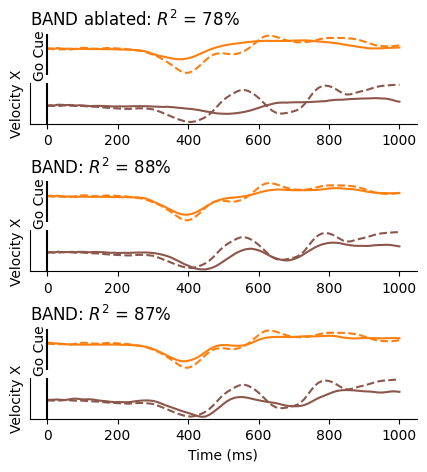

In [12]:
fig, axes = plt.subplots(8,1,figsize=(5,5))
select = [1,5]
plot_beh_pred(true_valid_beh, noci_behavior, 
              dir_index, t2p, axes[:2], 
              'all', 'AD', select = select, component=0,title="BAND ablated")
axes[1].set_xlabel('')
axes[2].axis('off')
plot_beh_pred(true_valid_beh, behavior, 
              dir_index, t2p, axes[3:5], 
              'all', 'AD', select = select, component=0,title="BAND")
axes[4].set_xlabel('')
axes[5].axis('off')
plot_beh_pred(true_valid_beh, Y_pred_seq2seq_rates, 
              dir_index, t2p, axes[6:8], 
              'all', 'AD', select = select, component=0,title="BAND")

# Make a print-ready figure

### calculate base LL

In [13]:
from scipy.stats import poisson
valid_mean_count = valid_data.mean(0).mean(0) # to get Hz -> x100
base_LL = poisson.logpmf(valid_data, valid_mean_count)
n_sp = valid_data.sum()

valid_LL = {'LFADS': poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_rates[0]), 
            'BAND': poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_rates[1]), 
            'LFADS_noci': poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_noci_rates[0]), 
            'BAND_noci': poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_noci_rates[1])}
valid_co_bps = {key: np.sum(valid_LL[key] - base_LL)/(n_sp * np.log(2)) for key in valid_LL.keys()}
valid_co_bps

{'LFADS': 0.1662572262959618,
 'BAND': 0.1645025728457354,
 'LFADS_noci': 0.16549641723366418,
 'BAND_noci': 0.15294326132312291}

### prepare factor in ordered trials

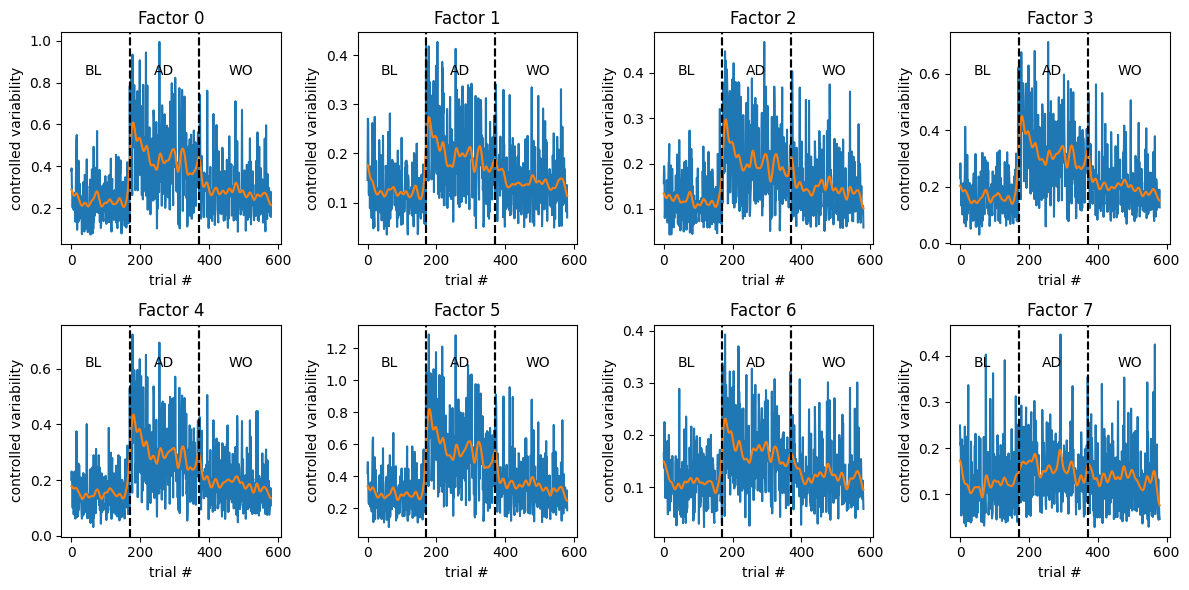

In [14]:
# # find number of BL and AD trials
# num_trials_per_epoch = [None for _ in range(3)]
# for e in [0,1,2]:
#     num_trials_per_epoch[e] = max(np.max(train_inds[train_epoch == e]),np.max(valid_inds[valid_epoch == e])) # potentially wrong if last trials in epoch are bad
# num_trials_per_epoch

factors_pull = np.concatenate([both_train_factors[1],both_factors[1]],axis=0)
factors_noci_pull = np.concatenate([both_train_factors_noci[1],both_factors_noci[1]],axis=0)
ids_pull = np.concatenate([train_inds,valid_inds],axis=0).copy()
epochs_pull = np.concatenate([train_epoch,valid_epoch],axis=0)
# valid_mask = np.concatenate([np.zeros_like(train_epoch),np.ones_like(valid_epoch)],axis=0)

ids_pull[epochs_pull == 1] = ids_pull[epochs_pull == 1] + 500
ids_pull[epochs_pull == 2] = ids_pull[epochs_pull == 2] + 1000

sort_inds = np.argsort(ids_pull)

fig, axes = plt.subplots(2,factors.shape[-1]//2, figsize=(12, 6))
for factor_id, ax in enumerate(axes.flatten()):
    fd = (factors_pull[sort_inds,:,factor_id]-factors_noci_pull[sort_inds,:,factor_id])
    ax.plot(fd.std(1), label='BAND')
    # gaussian filter
    from scipy.ndimage import gaussian_filter1d
    ax.plot(gaussian_filter1d(fd.std(1), 5))
    ax.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
    ax.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')
    n_BL = np.sum(epochs_pull==0)
    n_AD = np.sum(epochs_pull==1)
    n_WO = np.sum(epochs_pull==2)
    n = n_BL + n_AD + n_WO
    ax.axvline(n_BL, color='k', linestyle='--')
    ax.axvline(n_BL+n_AD, color='k', linestyle='--')
    ax.text(0.5 * n_BL / n, 0.8, 'BL', transform=ax.transAxes, ha='center')
    ax.text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=ax.transAxes, ha='center')
    ax.text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=ax.transAxes, ha='center')
    ax.set_title(f'Factor {factor_id}')
    ax.set_ylabel('controlled variability')
    ax.set_xlabel('trial #')

plt.tight_layout()

In [15]:
both_train_rates[1].shape, both_rates[1].shape, train_data.shape, valid_data.shape

((465, 101, 207), (116, 101, 207), (465, 101, 207), (116, 101, 207))

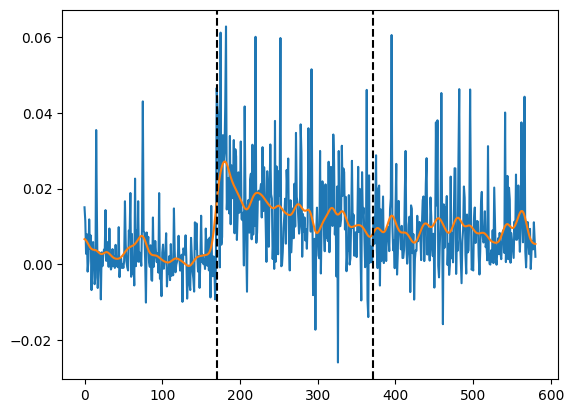

In [16]:
n_sp = np.concatenate([train_data.sum(1).sum(1),valid_data.sum(1).sum(1)],axis=0)
data_pull = np.concatenate([train_data,valid_data],axis=0)
base_LL_pull = poisson.logpmf(data_pull, data_pull.mean(0).mean(0))
cobps_pull = (np.concatenate([poisson.logpmf(train_data, (bin_size_ms / 1000) * both_train_rates[1]),
                             poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_rates[1]),
                             ],axis=0) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2)) 
cobps_noci_pull = (np.concatenate([poisson.logpmf(train_data, (bin_size_ms / 1000) * both_train_noci_rates[1]),
                             poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_noci_rates[1]),
                             ],axis=0) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2))
plt.plot(cobps_pull[sort_inds]- cobps_noci_pull[sort_inds])
# gaussian filter
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(cobps_pull[sort_inds] - cobps_noci_pull[sort_inds], 5))
plt.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
plt.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')

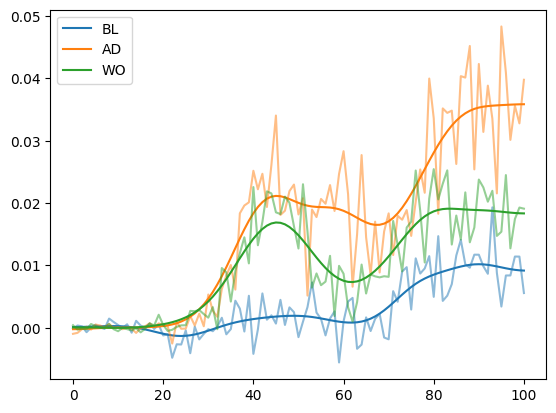

In [17]:
# n_sp = valid_data.sum(0).sum(-1)
# cobps = poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_rates[1]).sum(0).sum(-1)/(n_sp * np.log(2)) 
# cobps_noci = poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_noci_rates[1]).sum(0).sum(-1)/(n_sp * np.log(2))
# plt.plot(cobps - cobps_noci)

both_rates_pull = np.concatenate([both_train_rates[1],both_rates[1]],axis=0)
both_noci_rates_pull = np.concatenate([both_train_noci_rates[1],both_noci_rates[1]],axis=0)

for e, epoch_name in enumerate(['BL','AD','WO']):
    n_sp = data_pull[epochs_pull==e].sum(0).sum(-1)
    cobps = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2)) 
    cobps_noci = poisson.logpmf(data_pull[epochs_pull==e], (bin_size_ms / 1000) * both_noci_rates_pull[epochs_pull==e]).sum(0).sum(-1)/(n_sp * np.log(2))
    plt.plot(cobps - cobps_noci,alpha=0.5,c=f"C{e}")
    # gaussian filter
    plt.plot(gaussian_filter1d(cobps - cobps_noci, 5),label=epoch_name,c=f"C{e}")
plt.legend()


### then plot the figure

In [18]:
from goodman_panels import panels, panel_specs, label_panel, label_panels

In [19]:
def make_task_schematics(ax, x,y,r,aspect=1.,shown=np.ones(8)):

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # bbox = ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted())
    # aspect = bbox.width / bbox.height
    # print(aspect)

    # draw a circle around the center with 8 target directions
    theta = np.roll(np.linspace(0,2*np.pi,9)[:-1],3)
    x_t = x + r*np.cos(theta)
    y_t = y + r*np.sin(theta)*aspect

    for c, (s, xt, yt) in enumerate(zip(shown, x_t,y_t)):
        fill = {'facecolors': f'C{c}'} if s else {'facecolors': 'none'}
        ax.scatter(xlim[0] + (xlim[1] - xlim[0])*xt,
                    ylim[0] + (ylim[1] - ylim[0])*yt,
                    s=20,edgecolors=f'C{c}',linewidth=.5,
                    **fill)
    ax.scatter(xlim[0] + (xlim[1] - xlim[0]) * x,
                ylim[0] + (ylim[1] - ylim[0]) * y,
                s = 20, c='k', marker='+',linewidth=.5)

/tmp/ipykernel_3973582/467351109.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes['A0'].set_xticklabels(axes['A0'].get_xticklabels(), rotation=90)


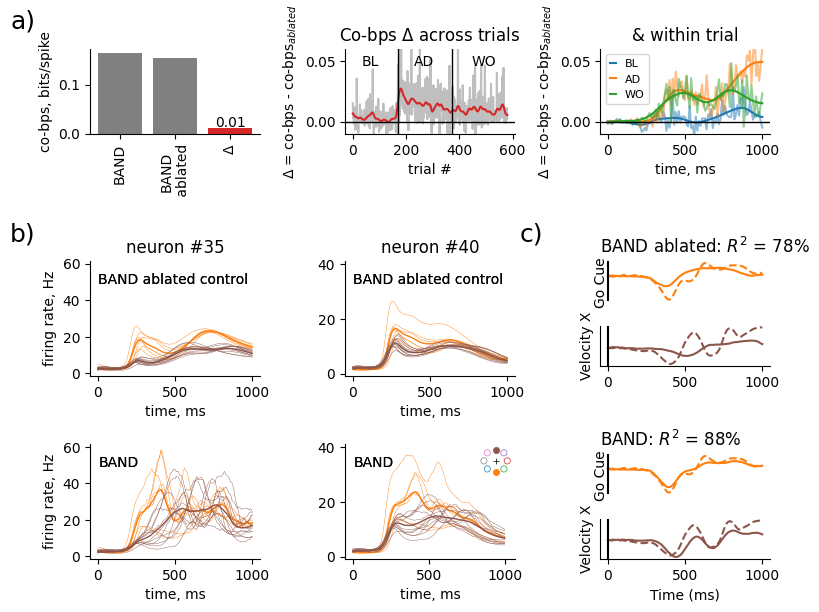

In [20]:
layout = '''
AAA
BBC
BBC
'''
fig = plt.figure(figsize=(8, 6))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.1, 'right': .95, 'bottom': 0.08, 'top': 0.93, 'hspace': 1.5, 'wspace': .5})
axes = {}
# for letter in 'C':
#     axes[letter] = ax = fig.add_subplot(specs[letter])
#     label_panel(ax, letter)
gs.set_width_ratios([1,1,1])
gs.set_height_ratios([1,1,1])

# subgs = specs['A'].subgridspec(1, 4, wspace=0.3)
# for i in range(4):
#     axes[f"A{i}"] = ax = fig.add_subplot(subgs[i])
# label_panel(axes['A0'], 'A')

subgs = specs['A'].subgridspec(1, 3, wspace=0.5)
subgs.set_width_ratios([1, 1, 1])
for i in range(3):
    axes[f"A{i}"] = ax = fig.add_subplot(subgs[i])
label_panel(axes['A0'], 'a', postfix=')')

subgs = specs['B'].subgridspec(2, 2, wspace=0.5)
for j in range(2):
    for i in range(2):
        if j == 0:
            axes[f"B{j}{i}"] = ax = fig.add_subplot(subgs[j,i])
        else:
            axes[f'B{j}{i}'] = ax = fig.add_subplot(subgs[j,i], sharey=axes[f'B0{i}'])
label_panel(axes['B00'], 'b', postfix=')')

subgs = specs['C'].subgridspec(2*2+1, 1, wspace=0.3)
for j in range(2*2+1):
    axes[f"C{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['C0'], 'c', postfix=')')

# select what to plot
factors = both_factors[1] # BAND

# Panel A: plot oscillating factor variability
axes['A0'].bar(['BAND', 'BAND\n ablated', r'$\Delta$'], 
               [valid_co_bps['BAND'], valid_co_bps['BAND_noci'], 
                valid_co_bps['BAND'] - valid_co_bps['BAND_noci']],
               color=['grey','grey','C3'])
axes['A0'].set_xticklabels(axes['A0'].get_xticklabels(), rotation=90)
axes['A0'].set_ylabel('co-bps, bits/spike')
axes['A0'].text(2, (valid_co_bps['BAND'] - valid_co_bps['BAND_noci'])*1.2,
                f"{valid_co_bps['BAND'] - valid_co_bps['BAND_noci']:.2f}", ha='center')

axes['A1'].plot(cobps_pull[sort_inds]- cobps_noci_pull[sort_inds],alpha=0.5,c='grey')
axes['A1'].plot(gaussian_filter1d(cobps_pull[sort_inds] - cobps_noci_pull[sort_inds], 5),c='C3')
n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO
axes['A1'].axvline(n_BL, color='k', linewidth=1)
axes['A1'].axvline(n_BL+n_AD, color='k', linewidth=1)
axes['A1'].axhline(0, color='k', linewidth=1)
axes['A1'].text(0.5 * n_BL / n, 0.8, 'BL', transform=axes['A1'].transAxes, ha='center')
axes['A1'].text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=axes['A1'].transAxes, ha='center')
axes['A1'].text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=axes['A1'].transAxes, ha='center')
axes['A1'].set_xlabel('trial #')
axes['A1'].set_ylabel(r'$\Delta$ = co-bps - co-bps$_{ablated}$')
axes['A1'].set_title(r'Co-bps $\Delta$ across trials')
axes['A1'].set_yticks([0,0.05])
axes['A1'].set_ylim([-0.01,0.06])

axes['A2'].set_title('& within trial')
time = np.arange(factors.shape[1])*bin_size_ms
for e, epoch_name in enumerate(['BL','AD','WO']):
    n_sp = valid_data[valid_epoch==e].sum(0).sum(-1)
    cobps = poisson.logpmf(valid_data[valid_epoch==e], (bin_size_ms / 1000) * both_rates[1][valid_epoch==e]).sum(0).sum(-1)/(n_sp * np.log(2)) 
    cobps_noci = poisson.logpmf(valid_data[valid_epoch==e], (bin_size_ms / 1000) * both_noci_rates[1][valid_epoch==e]).sum(0).sum(-1)/(n_sp * np.log(2))
    axes['A2'].plot(time, cobps - cobps_noci,alpha=0.5,c=f"C{e}")
    # gaussian filter
    axes['A2'].plot(time, gaussian_filter1d(cobps - cobps_noci, 5),label=epoch_name,c=f"C{e}")
axes['A2'].legend(loc='upper left',handlelength=.5,fontsize=8)
axes['A2'].set_xlabel('time, ms')
axes['A2'].set_ylabel(r'$\Delta$ = co-bps - co-bps$_{ablated}$')
axes['A2'].set_yticks([0,0.05])
axes['A2'].axhline(0, color='k', linewidth=1)
axes['A2'].set_ylim([-0.01,0.06])

select = [1,5] # directions to plot
for k, (n, sub) in enumerate(zip([35, 40], [select,select,select])):
    unique_dirs = np.unique(true_target_direction)
    time = np.arange(rates.shape[1]) * 10

    for i, (frs, title) in enumerate(zip([both_noci_rates[1], both_rates[1]],
                                        ['BAND ablated control', 'BAND'])):
        for j, d in enumerate(unique_dirs):
            if d in unique_dirs[sub]:
                mask = true_target_direction == d
                axes[f'B{i}{k}'].plot(
                    time,
                    frs[mask][..., n].mean(0),
                    linewidth=1,
                    c=f"C{j}",
                    label=d,
                )
                axes[f'B{i}{k}'].plot(
                    time, frs[mask][..., n].T, linewidth=0.3, c=f"C{j}"
                )

                if i == 0:
                    axes[f'B0{k}'].set_title(f"neuron #{n}")  # , firing rate")
                if k == 0:
                    axes[f'B{i}{k}'].set_ylabel("firing rate, Hz")
                axes[f'B{i}{k}'].set_xlabel("time, ms")
                axes[f'B{i}{k}'].text(0.05, 0.8, title, transform=axes[f'B{i}{k}'].transAxes, ha='left')
make_task_schematics(axes['B11'], 0.9,0.9,0.07,aspect=1.5,shown=[0,1,0,0,0,1,0,0])

# panel C
plot_beh_pred(true_valid_beh, noci_behavior, 
              dir_index, t2p, [axes[f'C{i}'] for i in range(2)], 
              'all', 'AD', select = select, component=0,title="BAND ablated")
axes['C1'].set_xlabel('')
axes['C2'].axis('off')
plot_beh_pred(true_valid_beh, behavior, 
              dir_index, t2p, [axes[f'C{i}'] for i in range(3,5)], 
              'all', 'AD', select = select, component=0,title="BAND")

for k in axes.keys():
    axes[k].spines['right'].set_visible(False)
    axes[k].spines['top'].set_visible(False)

plt.subplots_adjust(hspace=0.6)
# plt.tight_layout()
plt.savefig(f"figs/fig6.pdf")

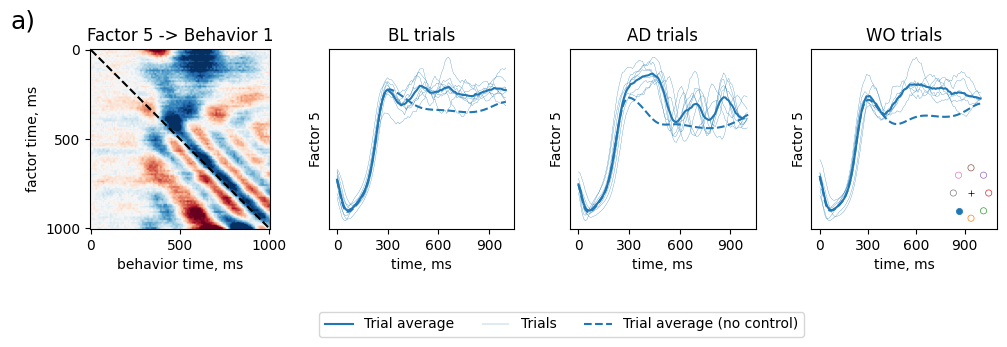

In [21]:
layout = '''
AAA
CCB
CCB
'''
fig = plt.figure(figsize=(10, 10))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.08, 'right': .99, 'bottom': 0.05, 'top': 0.95, 'hspace': 1, 'wspace': .3})
axes = {}
# for letter in 'C':
#     axes[letter] = ax = fig.add_subplot(specs[letter])
#     label_panel(ax, letter)
gs.set_width_ratios([1,1,1])
gs.set_height_ratios([1,1,1])

subgs = specs['A'].subgridspec(1, 4, wspace=0.3)
for i in range(4):
    axes[f"A{i}"] = ax = fig.add_subplot(subgs[i])
label_panel(axes['A0'], 'a', postfix=')')

# select what to plot
factor_id = 5
beh_id = 1
factors = both_factors[1] # BAND
time = np.arange(factors.shape[1]) * 10

# Panel A: plot oscillation weights & factors
r = torch.std(beh_W)*4
axes['A0'].imshow(beh_W[:,factor_id,:,beh_id].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
axes['A0'].set_xlabel('behavior time, ms')
axes['A0'].set_ylabel('factor time, ms')
axes['A0'].plot([0,seq_len-1], [0, seq_len-1], 'k--')
axes['A0'].set_title(f'Factor {factor_id} -> Behavior {beh_id}')
axes['A0'].set_xticks([0,50,100])
axes['A0'].set_xticklabels([0,500,1000])
axes['A0'].set_yticks([0,50,100])
axes['A0'].set_yticklabels([0,500,1000])

unique_dirs = np.unique(true_target_direction)

for e, e_title in enumerate(["BL", "AD", "WO"]):
    for k, d in enumerate(unique_dirs):
        if d in unique_dirs[[0]]:
            mask = (true_target_direction == d) & (valid_epoch == e)
            label = 'Trial average' if d == unique_dirs[0] else None
            axes[f'A{e+1}'].plot(
                time, factors[..., factor_id][mask].mean(0), linewidth=1.5, c=f"C{k}", label=label
            )
            label = ['Trials'] + [None for _ in range(np.sum(mask)-1)] if d == unique_dirs[0] else None
            axes[f'A{e+1}'].plot(
                time, factors[..., factor_id][mask].T, linewidth=0.2, c=f"C{k}", alpha=1, label=label
            )
            label = 'Trial average (no control)' if d == unique_dirs[0] else None
            axes[f'A{e+1}'].plot(
                time, both_factors_noci[1][..., factor_id][mask].mean(0), linewidth=1.5, linestyle='--', c=f"C{k}", alpha=1, label=label
            )
            axes[f'A{e+1}'].set_yticks([])
            axes[f'A{e+1}'].set_xlabel("time, ms")
            axes[f'A{e+1}'].set_ylabel(f"Factor {factor_id}")
            axes[f'A{e+1}'].set_title(f"{e_title} trials")
            axes[f'A{e+1}'].set_xticks([0, 300, 600, 900])
            if e == 0:
                axes[f'A{e+1}'].legend(loc=[-.05,-.6], ncol = 3 )

make_task_schematics(axes[f'A3'], 0.9, .2, 0.1,aspect=1.4,shown=[1,0,0,0,0,0,0,0])


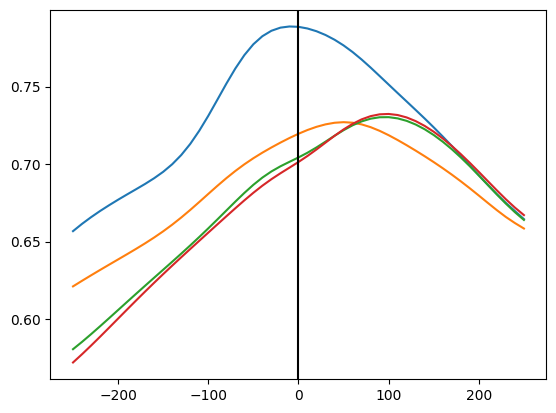

In [48]:

band = 1
def lagged_r2s(x_train, x_test, max_lag = 25):
    lags = np.arange(-max_lag,max_lag+1)
    r2s = []
    for lag in lags:
        # ridge regression between lagged factors and behavior
        if lag==max_lag:
            X_train = x_train[:,max_lag+lag:].reshape(-1,train_factors.shape[-1])
            X_test = x_test[:,max_lag+lag:].reshape(-1,factors.shape[-1])
        else:
            X_train = x_train[:,max_lag+lag:-max_lag+lag].reshape(-1,train_factors.shape[-1])
            X_test = x_test[:,max_lag+lag:-max_lag+lag].reshape(-1,factors.shape[-1])

        Y_train = true_train_beh[:,max_lag:-max_lag].reshape(-1,true_train_beh.shape[-1])
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(true_valid_beh[:,max_lag:-max_lag].shape)
        r2 = r2_score(Y_pred, true_valid_beh[:,max_lag:-max_lag])
        r2s.append(r2)
    return -lags*10, r2s

plt.plot(*lagged_r2s(both_train_factors[band],both_factors[band]))
plt.plot(*lagged_r2s(both_train_factors_noci[band],both_factors_noci[band]))

plt.plot(*lagged_r2s(both_train_factors[0],both_factors[0]))
plt.plot(*lagged_r2s(both_train_factors_noci[0],both_factors_noci[0]))
plt.axvline(0,c='k')

In [38]:
true_b

Help on function r2_score in module lfads_torch.metrics:

r2_score(preds, targets)
    Computes an isotropic R2 metric
    (almost like a classic anisotropic one, but isotropic)

